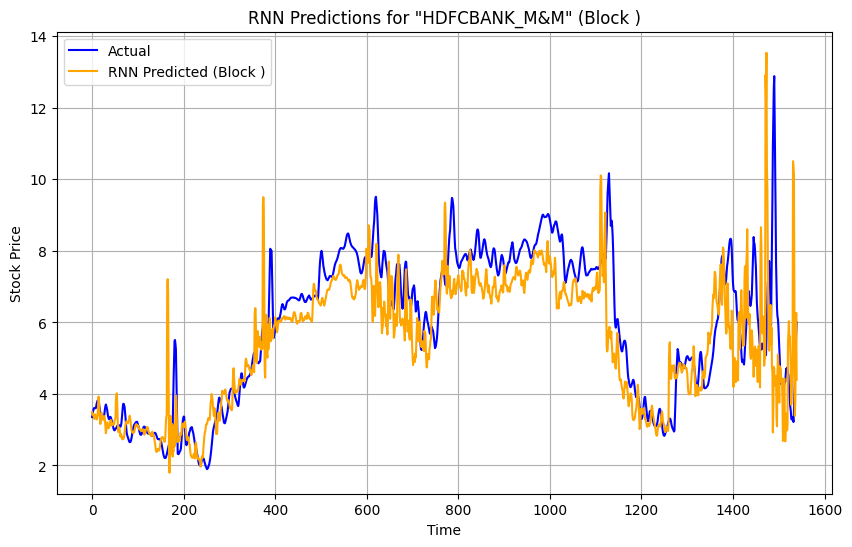

Evaluated RNN for predicted_series_rnn_block1_w20.csv -> R2: 0.09412953882207532, RMSE: 2.952073968133295, MAE: 1.7328778014938506, MAPE: 0.3416785745217186


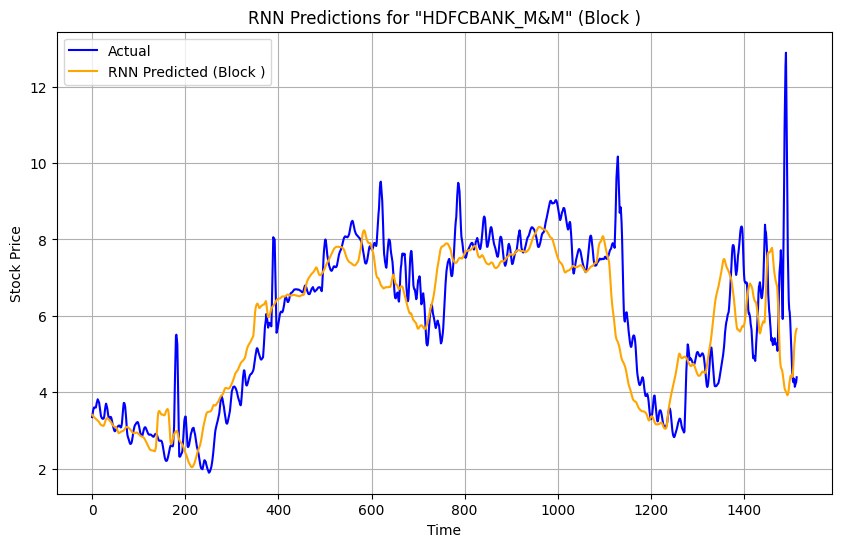

Evaluated RNN for predicted_series_rnn_block30_w20.csv -> R2: 0.4177399923779189, RMSE: 2.346151993670531, MAE: 1.4326544335638394, MAPE: 0.2961026987850232


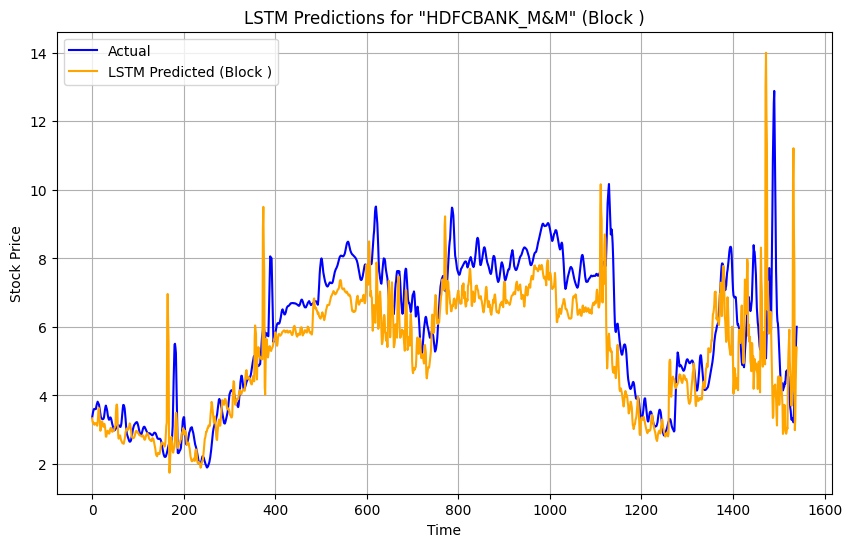

Evaluated LSTM for predicted_series_lstm_block1_w20.csv -> R2: 0.07278954225841923, RMSE: 2.9619333880702876, MAE: 1.644657233588, MAPE: 0.32014057650054445


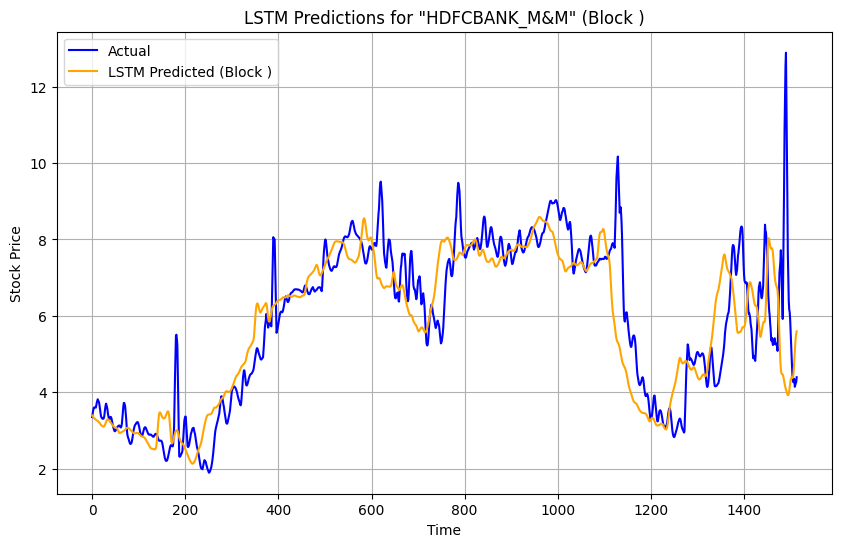

Evaluated LSTM for predicted_series_lstm_block30_w20.csv -> R2: 0.43004809217506873, RMSE: 2.320746256837438, MAE: 1.407031000581948, MAPE: 0.2908444390427945
Evaluation results saved to 'evaluation_results_block_comparison.csv'.


In [1]:
# Import necessary libraries
from scipy.io import loadmat
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Load training and test data (already preprocessed)
train_data_file = pd.read_csv("train_data2.csv")
test_data_file = pd.read_csv("test_data2.csv")

# Extract stock pair names
names = train_data_file.columns.tolist()

# Filenames for the precomputed RNN and LSTM predictions
rnn_files = [
    "predicted_series_rnn_block1_w20.csv",
    "predicted_series_rnn_block30_w20.csv"
]

lstm_files = [
    "predicted_series_lstm_block1_w20.csv",
    "predicted_series_lstm_block30_w20.csv"
]

# Initialize lists for storing evaluation metrics
evaluation_results = []

# Function to evaluate predictions for both RNN and LSTM models and plot them
def evaluate_and_plot_predictions(file, model_type, block_size):
    predicted_series = pd.read_csv(file, index_col=0).to_dict(orient='list')
    
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    mape_scores = []

    # Pick a stock for visualization (e.g., the first stock in the dataset)
    stock = names[0]  # For example, the first stock pair

    # Iterate over each stock pair and evaluate the predictions
    for stock in names:
        # Load the actual test data for comparison
        test_data = test_data_file[stock]
        validation_data = np.array(test_data).reshape(-1, 1)
        
        # Initialize the scaler and scale the actual test data for evaluation
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_dataset_validation = scaler.fit_transform(validation_data)
        
        # Predicted data (already loaded from .csv)
        preds = np.array(predicted_series[stock])
        
        # Inverse scale the actual test data for evaluation
        y_test = scaler.inverse_transform(scaled_dataset_validation)

        # Ensure consistent length between y_test and predictions
        min_length = min(len(y_test), len(preds))
        y_test = y_test[:min_length]  # Truncate y_test
        preds = preds[:min_length]    # Truncate predictions
        
        # Evaluate Predictions
        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mape = mean_absolute_percentage_error(y_test, preds)
        mae = mean_absolute_error(y_test, preds)

        # Append results for the current stock
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        mape_scores.append(mape)
    
        # Plot predictions for one stock to show the difference between small and large block sizes
        if stock == names[0]:
            plt.figure(figsize=(10, 6))
            plt.plot(y_test, label="Actual", color='blue')
            plt.plot(preds, label=f"{model_type} Predicted (Block {block_size})", color='orange')
            plt.title(f"{model_type} Predictions for {stock} (Block {block_size})")
            plt.legend()
            plt.xlabel("Time")
            plt.ylabel("Stock Price")
            plt.grid(True)
            plt.show()

    # Store the evaluation metrics for the current file
    evaluation_results.append({
        'File': file,
        'Model': model_type,
        'Block Size': block_size,
        'R2': np.mean(r2_scores),
        'RMSE': np.mean(rmse_scores),
        'MAE': np.mean(mae_scores),
        'MAPE': np.mean(mape_scores)
    })

    # Print metrics for the current file
    print(f"Evaluated {model_type} for {file} -> R2: {np.mean(r2_scores)}, RMSE: {np.mean(rmse_scores)}, MAE: {np.mean(mae_scores)}, MAPE: {np.mean(mape_scores)}")


# Loop through RNN files for block 1 and block 30 and plot them
for rnn_file in rnn_files:
    block_size = rnn_file.split("_")[2][5:]  # Extract block size from filename
    evaluate_and_plot_predictions(rnn_file, "RNN", block_size)

# Loop through LSTM files for block 1 and block 30 and plot them
for lstm_file in lstm_files:
    block_size = lstm_file.split("_")[2][5:]  # Extract block size from filename
    evaluate_and_plot_predictions(lstm_file, "LSTM", block_size)

# Save evaluation metrics to a CSV file for further analysis
evaluation_df = pd.DataFrame(evaluation_results)
evaluation_df.to_csv('evaluation_results_block_comparison.csv', index=False)

print("Evaluation results saved to 'evaluation_results_block_comparison.csv'.")
